# 9_Rna_Evaluation_Simplified.ipynb

## Visão Geral

Este notebook carrega o modelo previamente treinado (`final_residual_model.h5`) e avalia seu desempenho em um dataset de teste (origem: arquivo JSON). Em seguida, gera gráficos para análise dos erros. Nesta versão, foram adicionados gráficos que focam nos valores centrais (já que a maioria dos erros está próxima de zero) e uma estratificação dos resultados por faixa de latitude, a fim de visualizar melhor a distribuição dos erros e identificar outliers.

> **Observação**: Se a normalização utilizada no treino for diferente, o ideal é salvar o objeto `scaler` e reaplicá-lo; aqui refitamos com `StandardScaler` para simplificar.

In [3]:
import os
import ijson
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Configurações iniciais
sns.set_theme(style="whitegrid")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Caminhos
JSON_PATH = "Dataset_Vetor.json"     # Altere conforme seu JSON de teste
MODEL_PATH = "final_residual_model.h5" # Modelo salvo do treino

# Colunas target
TARGET_COLS = ["diferencalatitudeMetros", "diferencalongitudeMetros"]

# Limite de amostras (None para usar todas)
MAX_SAMPLES = None

if not tf.config.list_physical_devices('GPU'):
    print("[AVISO] Nenhuma GPU detectada. Usando CPU.")
else:
    print(f"[INFO] GPU detectada: {[gpu.name for gpu in tf.config.list_physical_devices('GPU')]}")

[INFO] GPU detectada: ['/physical_device:GPU:0']


In [4]:
def discover_feature_keys(json_path, max_samples=None):
    feature_keys_set = set()
    with open(json_path, "rb") as f:
        parser = ijson.items(f, "item")
        count = 0
        for record in parser:
            for k in record.keys():
                if k not in TARGET_COLS:
                    feature_keys_set.add(k)
            count += 1
            if max_samples and count >= max_samples:
                break
    return sorted(feature_keys_set)

def dict_to_numpy_fixed(record, feature_keys):
    # Verifica se todas as targets existem
    for col in TARGET_COLS:
        if col not in record:
            return None, None
    try:
        lat = float(record["diferencalatitudeMetros"])
        lon = float(record["diferencalongitudeMetros"])
    except:
        return None, None
    y_array = np.array([lat, lon], dtype=np.float32)
    X_array = np.zeros(len(feature_keys), dtype=np.float32)
    for i, k in enumerate(feature_keys):
        try:
            X_array[i] = float(record.get(k, 0.0))
        except:
            X_array[i] = 0.0
    return X_array, y_array

def read_dataset(json_path, feature_keys, max_samples=None):
    dataX, dataY = [], []
    count = 0
    with open(json_path, "rb") as f:
        parser = ijson.items(f, "item")
        for record in parser:
            X, y = dict_to_numpy_fixed(record, feature_keys)
            if X is not None and y is not None:
                dataX.append(X)
                dataY.append(y)
            count += 1
            if max_samples and count >= max_samples:
                break
    return np.array(dataX, dtype=np.float32), np.array(dataY, dtype=np.float32)

In [5]:
# 1) Descobrir features e carregar dados
print("[INFO] Descobrindo features...")
feature_keys = discover_feature_keys(JSON_PATH, max_samples=MAX_SAMPLES)
if not feature_keys:
    raise ValueError("Não encontrou features. Verifique seu JSON.")

print("[INFO] Lendo dados...")
X_all, y_all = read_dataset(JSON_PATH, feature_keys, max_samples=MAX_SAMPLES)
print(f"Formato do dataset X: {X_all.shape}")
print(f"Formato do dataset y: {y_all.shape}")

print(f"[INFO] Carregando modelo {MODEL_PATH}...")
model = load_model(MODEL_PATH)
print("Modelo carregado com sucesso!")

[INFO] Descobrindo features...
[INFO] Lendo dados...
Formato do dataset X: (419878, 645)
Formato do dataset y: (419878, 2)
[INFO] Carregando modelo final_residual_model.h5...


2025-05-04 20:46:02.401806: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-04 20:46:02.402075: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-04 20:46:02.402249: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-04 20:46:02.523024: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-04 20:46:02.523139: I tensorflow/compile

Modelo carregado com sucesso!


In [6]:
# 2) Split e normalização
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.45, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"[INFO] X_test shape: {X_test_scaled.shape}")
print(f"[INFO] y_test shape: {y_test.shape}")

[INFO] X_test shape: (188946, 645)
[INFO] y_test shape: (188946, 2)


In [7]:
# 3) Avaliação do modelo
print("[INFO] Avaliando o modelo no conjunto de TEST...")
results = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Loss (MSE)={results[0]:.4f}, MAE={results[1]:.4f}, MSE={results[2]:.4f}")

[INFO] Avaliando o modelo no conjunto de TEST...


2025-05-04 20:46:11.906165: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Loss (MSE)=1.0198, MAE=0.1846, MSE=0.9437


In [8]:
# 4) Predições e criação do DataFrame
print("Calculando predições...")
y_pred = model.predict(X_test_scaled, batch_size=8192, verbose=0)
print(f"Predições obtidas: {y_pred.shape}")

# Criar DataFrame
df_test = pd.DataFrame({
    'real_lat': y_test[:, 0],
    'real_lon': y_test[:, 1],
    'pred_lat': y_pred[:, 0],
    'pred_lon': y_pred[:, 1]
})

df_test['err_lat'] = df_test['pred_lat'] - df_test['real_lat']
df_test['err_lon'] = df_test['pred_lon'] - df_test['real_lon']
df_test['dist_2d'] = np.sqrt(df_test['err_lat']**2 + df_test['err_lon']**2)

print("Estatísticas gerais dos erros:")
print(df_test[['err_lat','err_lon','dist_2d']].describe())

Calculando predições...
Predições obtidas: (188946, 2)
Estatísticas gerais dos erros:
             err_lat        err_lon        dist_2d
count  188946.000000  188946.000000  188946.000000
mean        0.037066       0.061860       0.287457
std         0.787054       1.123760       1.343450
min       -54.852699     -70.104553       0.001059
25%        -0.066391      -0.033506       0.129360
50%         0.044170       0.070262       0.199897
75%         0.154490       0.175901       0.295633
max        76.462952     163.627975     178.914154


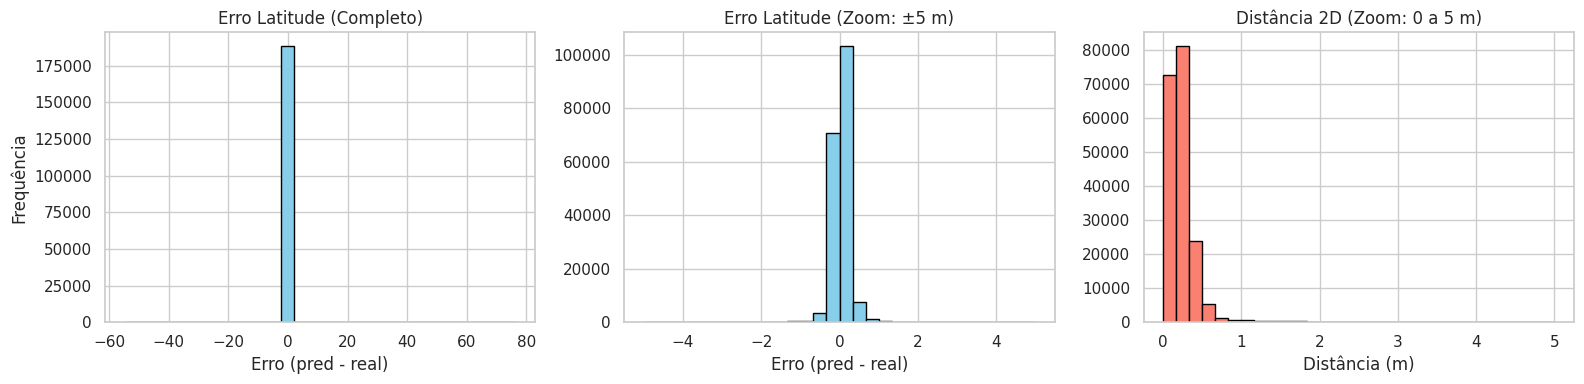

/tmp/ipykernel_239/3530416534.py:37: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_test['err_lat'], shade=True, color='skyblue')
/tmp/ipykernel_239/3530416534.py:42: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_test['err_lon'], shade=True, color='lightgreen')
/tmp/ipykernel_239/3530416534.py:47: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_test['dist_2d'], shade=True, color='salmon')


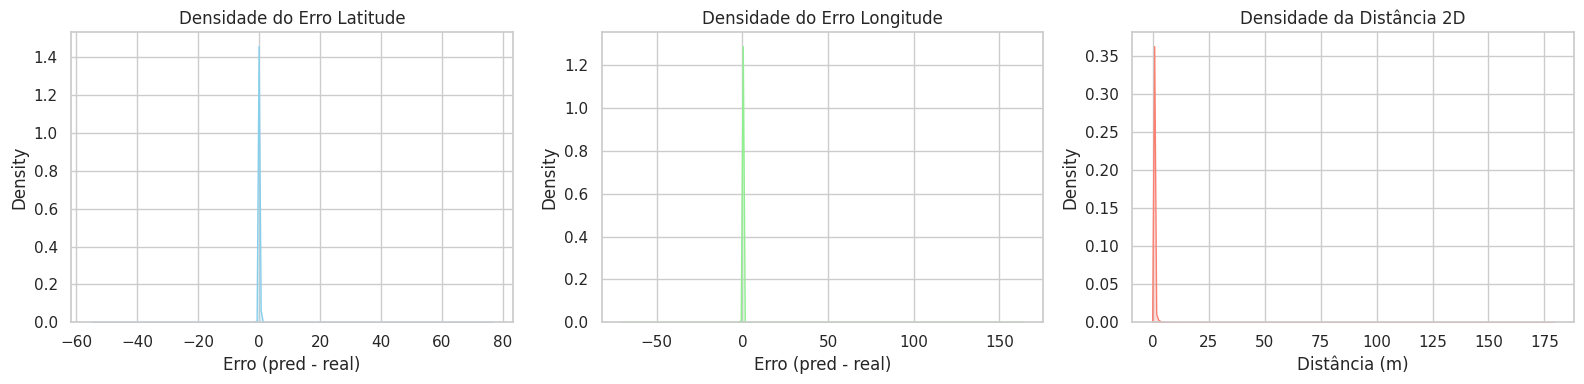

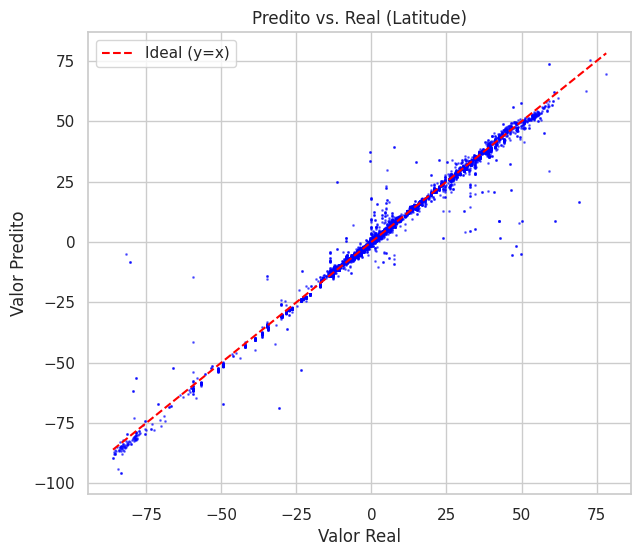

/tmp/ipykernel_239/3530416534.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='faixa', y='err_lat', data=df_test, palette='Blues')
/tmp/ipykernel_239/3530416534.py:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='faixa', y='dist_2d', data=df_test, palette='Oranges')


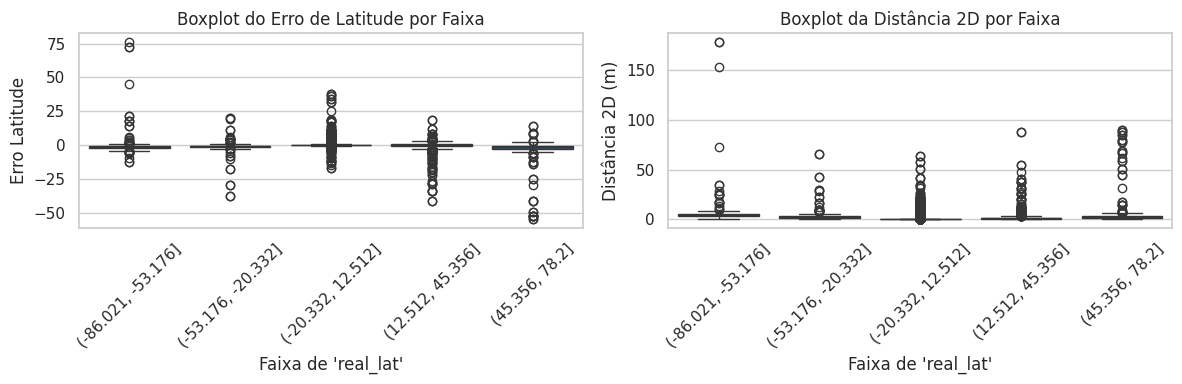

In [9]:
### 5) Gráficos simplificados

## 5.1 Histogramas (com escala completa e com zoom na região central)

limite_err = 5  # Foco para erros entre -5 e 5
limite_dist = 5  # Foco para a distância 2D de 0 até 5 m

plt.figure(figsize=(16, 4))

# Histograma do erro de latitude - escala completa
plt.subplot(1, 3, 1)
plt.hist(df_test['err_lat'], bins=30, color='skyblue', edgecolor='black')
plt.title('Erro Latitude (Completo)')
plt.xlabel('Erro (pred - real)')
plt.ylabel('Frequência')

# Histograma do erro de latitude - zoom
plt.subplot(1, 3, 2)
plt.hist(df_test['err_lat'], bins=30, range=(-limite_err, limite_err), color='skyblue', edgecolor='black')
plt.title(f'Erro Latitude (Zoom: ±{limite_err} m)')
plt.xlabel('Erro (pred - real)')

# Histograma da distância 2D - zoom
plt.subplot(1, 3, 3)
plt.hist(df_test['dist_2d'], bins=30, range=(0, limite_dist), color='salmon', edgecolor='black')
plt.title(f'Distância 2D (Zoom: 0 a {limite_dist} m)')
plt.xlabel('Distância (m)')

plt.tight_layout()
plt.show()

## 5.2 Gráficos de densidade (KDE)

plt.figure(figsize=(16, 4))

plt.subplot(1, 3, 1)
sns.kdeplot(df_test['err_lat'], shade=True, color='skyblue')
plt.title('Densidade do Erro Latitude')
plt.xlabel('Erro (pred - real)')

plt.subplot(1, 3, 2)
sns.kdeplot(df_test['err_lon'], shade=True, color='lightgreen')
plt.title('Densidade do Erro Longitude')
plt.xlabel('Erro (pred - real)')

plt.subplot(1, 3, 3)
sns.kdeplot(df_test['dist_2d'], shade=True, color='salmon')
plt.title('Densidade da Distância 2D')
plt.xlabel('Distância (m)')

plt.tight_layout()
plt.show()

## 5.3 Gráfico de dispersão: Valores Reais vs. Preditados para Latitude
plt.figure(figsize=(7, 6))
plt.scatter(df_test['real_lat'], df_test['pred_lat'], s=1, alpha=0.5, color='blue')
plt.plot([df_test['real_lat'].min(), df_test['real_lat'].max()], 
         [df_test['real_lat'].min(), df_test['real_lat'].max()], 
         color='red', linestyle='--', label='Ideal (y=x)')
plt.title('Predito vs. Real (Latitude)')
plt.xlabel('Valor Real')
plt.ylabel('Valor Predito')
plt.legend()
plt.show()

## 5.4 Boxplots estratificados por faixa de latitude

# Criar 5 faixas com base em 'real_lat'
bins = np.linspace(df_test['real_lat'].min(), df_test['real_lat'].max(), 6)
df_test['faixa'] = pd.cut(df_test['real_lat'], bins=bins, include_lowest=True)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.boxplot(x='faixa', y='err_lat', data=df_test, palette='Blues')
plt.xticks(rotation=45)
plt.title('Boxplot do Erro de Latitude por Faixa')
plt.xlabel("Faixa de 'real_lat'")
plt.ylabel('Erro Latitude')

plt.subplot(1, 2, 2)
sns.boxplot(x='faixa', y='dist_2d', data=df_test, palette='Oranges')
plt.xticks(rotation=45)
plt.title('Boxplot da Distância 2D por Faixa')
plt.xlabel("Faixa de 'real_lat'")
plt.ylabel('Distância 2D (m)')

plt.tight_layout()
plt.show()

In [10]:
# 6) Estratificação adicional e estatísticas por faixa

df_group = df_test.groupby('faixa')['dist_2d'].describe()
print("Estatísticas por faixa (real_lat) para a distância 2D:")
display(df_group)

Estatísticas por faixa (real_lat) para a distância 2D:


,count,mean,std,min,25%,50%,75%,max
faixa,,,,,,,,
"(-86.021, -53.176]",198.0,8.118352,21.419847,0.602852,2.885106,4.302857,5.291532,178.914154
"(-53.176, -20.332]",417.0,3.269850,6.073130,0.164729,1.514602,2.379544,3.138552,65.583092
"(-20.332, 12.512]",186025.0,0.244481,0.562853,0.001059,0.128299,0.197627,0.290513,63.232441
"(12.512, 45.356]",2030.0,1.815549,4.630261,0.051258,0.614225,0.998059,1.597410,87.692993
"(45.356, 78.2]",276.0,7.890499,18.680817,0.154011,1.430114,2.229335,3.214300,90.195282


## Conclusão

Neste notebook simplificado, avaliamos o modelo salvo usando métricas e geramos gráficos para analisar a distribuição dos erros. Foram incluídos histogramas com e sem zoom para evidenciar que a maioria dos erros está próxima de zero, gráficos de densidade para visualizar a concentração dos erros, um gráfico de dispersão (valores reais versus preditos) para verificar o alinhamento das predições, e boxplots estratificados por faixa de latitude para identificar possíveis diferenças regionais. 

Essas visualizações permitem uma análise mais detalhada dos resultados, facilitando a identificação dos casos extremos (outliers) e a verificação se o modelo tem um desempenho consistente em diferentes faixas de latitude.